# Final Project
## CS166 // Prof Scheffler
### Soren Gran // April 2019

# Introduction to Roomba
From Wikipedia (https://en.wikipedia.org/wiki/Roomba):  
"Roomba's sensors can detect  
- the presence of obstacles
- dirty spots on the floor
- steep drops such as stairs"  

New Roombas are capable of mapping a room but frankly I do not feel capable of coding that function. Fortunately, old Roomba did not have that capability so consider this a study on early Roombas.

My Roomba will be able to recognize only obstacles (anything that prevents the Roomba's movement, including walls, drops/stairs, and chairs/tables/etc.) that are in front of it.

## BEHAVIOR
We are working with six strategies for Roomba movement.  
#### Strategy 1:
This strategy is most simple. The Roomba moves forward until it hits an obstacle or wall. Then it turns left or right based on the prescribed probability (usually .5).  
#### Strategy 2:
This strategy is more systematic. The Roomba goes straight, and when it hits an obstacle or wall, it turns left, goes forward one, and then turns left again (effectively turning around but moving adjacently to where it was before). The next time it hits a wall or obstacle, it does the same thing but with right turns.  
This movement looks like this (`*` is the starting point).  
`*> -> -> -> ->  
 <- <- <- <- <-  
 -> -> -> -> ->`  
 In this strategy, the Roomba only moves horizontally.  
#### Strategy 3:
Strategy 3 is a modification of Strategy 2. The issue with Strat 2 is that once it reaches a wall parallel to its movement, it will continue to move parallel to that wall and stop making progress. The improvement of Strat 3 is that when the Roomba has been in the same row twice, meaning it is stuck parallel to a wall (or two obstacles), the Roomba will reverse its turn sequence allowing it to turn away from the wall and work its way back in the other direction.  
Strat 3 does this by keeping track of how many times the Roomba has been in the same row. If that number exceeds 2, then the Roomba will change direction the next time it hits the obstacle. If the current row is different from the previous row, then the count returns to zero.  
In this strategy, the Roomba only moves horizontally.  
#### Strategy 4:
Strategy 4 is a modification of Strategy 3. The issue with Strat 3 is that it is very possible, if obstacles are set up correctly that the Roomba is incapable or entering a portion of the room. Strat 4 helps improve the Roomba's performance by adding another parameter that keeps track of how many times the Roomba reversed its turn sequence, as it does in Strat 3. This addition means that when the Roomba has reached one side of the room and then the other side of the room, the new behavior will kick in. This behavior is that the Roomba changes the alignment of its movement. It will change its movement from horizontal to vertical or vice versa. This will allow the Roomba to reach other parts of the room.  
#### Strategy 5:
Strategy 5 is a modification of Strategy 1. It is the same with strategy 1 but with an added random component, where at every step there is a chance (probability specified by user - I usually use .2) that it will turn left or right. Under Strategy 1, the Roomba would likely end up going in squares and was incapable of reaching large parts of the room. This addition enables the Roomba to reach virtually any section of the room.  
#### Strategy 6:
This strategy is a combination of Strategies 4 and 5. It is the exact same as Strategy 4 but with the randomization component of Strategy 5, so that the Roomba will randomly turn. Otherwise, its behavior follows Strat 4.  


## ASSUMPTIONS
My code operates on a few assumptions:  
- Rectangular rooms  
- Starts with 100% dirty room  
- Starting position is randomly selected in the middle

## ROOMBA CLASS
- Controls the movement of the Roomba (direction and stepping forward)

Attributes:
- probability of turning right
- room diagram, only used for looking in front of the roomba.  
  This room is only used to look at what is in front of the roomba and it not used to keep track of clean and dirty cells.
- strategy of roomba movement we will be employing

## ROOM CLASS
- Initializes the Roomba class
- Initializes the room, consisting of dirty/clean cells and obstacle cells
- The borders of the arrays represent the walls, instead of periodic boundaries

Attributes:
- length of room (length of each array)
- width of room (number of arrays)
- density of obstacles, randomly distributed among the room
- probability of roomba turning right
- number of times the roomba will step
- strategy of roomba movement we will be employing
- (strat_5) probability of random turn at any step
- (visualize) whether or not we want to visualize the roomba's movement.
    When we are doing hundreds of trials, we do not want to visualize.

## STRATEGY COMPARISON METRICS
- Average % clean on a rectangular room with random obstacles (baseline)
- % clean as obstacle density increases
- How cleanliness of the room increases as steps go by

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

In [25]:
class Roomba():
    def __init__(self, turn_prob, room, strategy):
        '''
        Initialize  the Roomba object
        
        Attributes:
        - probability of turning right
        - room diagram, only used for looking in front of the roomba. 
            This room is only used as a map and it not used to keep track of clean and dirty cells.
        - strategy of roomba movement we will be employing
        '''
        self.turn_prob = turn_prob
        self.room = room
        self.strategy = strategy
        '''
        random starting position
        if the position is occupied by an obstacle,we keep generating random positions until
        we generate an empty position
        '''
        y_guess = np.random.choice(range(len(room))) # random row
        x_guess = np.random.choice(range(len(room[0]))) # random column
        while room[y_guess][x_guess] == 10: # as long as this position is not an obstacle
            y_guess = np.random.choice(range(len(room)))
            x_guess = np.random.choice(range(len(room[0])))
        self.y_coord = y_guess
        self.x_coord = x_guess

        
        '''
        starting direction = 1 (arbitrarily)
        0 = north
        1 = east
        2 = south
        3 = west
        '''
        self.direction = 1
        
        '''
        When we employ the right-right-left-left strategy (strategy 2) , we must keep track
        of our previous two turns to know which way to turn this time
        '''
        self.prev_turn = 2 # for strategy 2, we will start with two right turns
        
        '''
        When we employ the improved right-right-left-left strategy (strategy 3), we must keep track of
        if we have been stuck in the same row multiple times
        '''
        self.prev_row = self.y_coord
        self.strat_3 = 0
        
        '''
        When we employ strategy 4, which is a modified version of strategy 3, we must keep track of how
        many times we get stuck in the same row multiple times. When we have done so twice, we change
        direction entirely from horizontal to vertical.
        '''
        self.strat_4 = 0
        
        
        
    def turn(self):
        if self.strategy == 1 or self.strategy == 5:
            # chance of turning right or left
            if np.random.random() < self.turn_prob:
                self.direction = (self.direction + 1) % 4
            else:
                self.direction = (self.direction - 1) % 4
        elif self.strategy == 2 or self.strategy == 3 or self.strategy == 4 or self.strategy == 6:
            
            if self.strategy == 3 or self.strategy == 4 or self.strategy == 6:
                # if we have stayed in the same row multiple times in a row,
                # we change the turn progression order from left-left-right-right
                # by increasing the count so that we skip one turn series,
                # resulting in left-left-right-right-right-right-left-left.
                if self.strat_3 == 2:
                    self.prev_turn += 1
                    self.strat_4 += 1
                    
            if self.strategy == 4 or self.strategy == 6:
                # once we have changed the turn progression twice, we assume that we
                # have cleaned the room wall-to-wall in this orientation so we make one
                # turn, changing the alignment from vertical to horizontal or vice versa.
                if self.strat_4 == 2:
                    self.direction = (self.direction - 1) % 4
                    self.prev_row = -1
                    self.strat_3 = 0
                    self.strat_4 = 0

            # every other turn, we turn right twice
            if self.prev_turn % 2 == 0:
                self.direction = (self.direction + 1) % 4
                if self.check_ahead():
                    self.move()
                self.direction = (self.direction + 1) % 4
                self.prev_turn += 1
                
                if self.direction == 1 or self.direction == 3:
                    # we want to check if we have stayed in the same row
                    if self.y_coord == self.prev_row:
                        self.strat_3 += 1
                    else:
                        self.strat_3 = 0
                else:
                    if self.x_coord == self.prev_row:
                        self.strat_3 += 1
                    else:
                        self.strat_3 = 0
            else: # here we turn left twice
                self.direction = (self.direction - 1) % 4
                if self.check_ahead():
                    self.move()
                self.direction = (self.direction - 1) % 4
                self.prev_turn += 1
                if self.y_coord == self.prev_row:
                    self.strat_3 += 1
                else:
                    self.strat_3 = 0
            
            # here we keep track of the previous row every turn
            if self.direction == 1 or self.direction == 3:
                self.prev_row = int(self.y_coord)
            else:
                self.prev_row = int(self.x_coord)

            
                
    def check_ahead(self):
        if self.direction == 0: # moving north
            if self.y_coord == 0: # if we are at the northern edge of the room
                return False
            elif self.room[self.y_coord - 1][self.x_coord] == 10: # if there is an obstacle in front of us
                return False
            else: # if we are all clear
                return True
        elif self.direction == 1: # moving east
            if self.x_coord == len(self.room[0]) - 1: # if we are at the eastern edge of the room
                return False
            elif self.room[self.y_coord][self.x_coord + 1] == 10: # if there is an obstacle in front of us
                return False
            else: # if we are all clear
                return True
        elif self.direction == 2: # moving south
            if self.y_coord == len(self.room) - 1: # if we are at the southern edge of the room
                return False
            elif self.room[self.y_coord + 1][self.x_coord] == 10: # if there is an obstacle in front of us
                return False
            else: # if we are all clear
                return True
        else: # self.direction == 3 moving west
            if self.x_coord == 0: # if we are at the western edge of the room
                return False
            elif self.room[self.y_coord][self.x_coord - 1] == 10: # if there is an obstacle in front of us
                return False
            else: # if we are all clear
                return True
    
    def move(self):
        if self.direction == 0: # moving north
            self.y_coord -= 1
        elif self.direction == 1: # moving east
            self.x_coord += 1
        elif self.direction == 2: # moving south
            self.y_coord += 1
        else: # self.direction == 3 moving west
            self.x_coord -= 1
    
    def step(self):
        if self.check_ahead(): # if all is clear in front of us
            self.move() # we keep moving in the same direction
        else: # if all is not clear (obstacle or edge of room)
            self.turn() # change direction

class Room():
    def __init__(self, length, width, density, turn_prob, steps, strategy, strat_5, visualize = False):
        '''
        Initialize  the room object
        Attributes:
        - length of room (length of each array)
        - width of room (number of arrays)
        - density of obstacles, randomly distributed among the room
        - probability of roomba turning right
        - number of times the roomba will step
        - strategy of roomba movement we will be employing
        - (strat_5) probability of random turn at any step
        - (visualize) whether or not we want to visualize the roomba's movement.
            When we are doing hundreds of trials, we do not want to visualize.
        '''
        self.length = length
        self.width = width
        self.density = density
        self.turn_prob = turn_prob
        self.steps = steps
        self.strategy = strategy
        self.strat_5 = strat_5
        self.visualize = visualize
        
        self.num_obstacles = round(length*width*density)
        '''
        The room will be initialized based on the prescribed length and width.
        The obstacles will be put in the front of the array and then shuffled.
        Every empty space will be dirty.
        '''
        self.room = np.zeros(self.width * self.length)
        for i in range(self.num_obstacles):
            self.room[i] = 10 # obstacle
        np.random.shuffle(self.room)
        self.room = self.room.reshape(self.width, self.length)
        
        '''
        We want to see how strategies perform over time, too. To do so, we will check the cumulative
        room cleanliness to see if some strategies are more consistent in cleaning the room
        while others clean the first half quickly and then struggle to clean the second half.
        '''
        self.cum_clean = []
        
    def measure(self):
        clean_count = 0
        total_count = self.length*self.width - self.num_obstacles
        for row in self.room:
            for cell in row:
                if cell == 3:
                    clean_count += 1
        return clean_count/total_count
    
    def display_room(self, y_coord, x_coord):
        copy_room = self.room.copy()
        copy_room = copy_room.tolist()
        copy_room[y_coord][x_coord] = 20
        plt.imshow(copy_room)

    
    def start_simulation(self):
        roomba = Roomba(self.turn_prob, self.room, self.strategy)
        self.room[roomba.y_coord][roomba.x_coord] = 3
        if self.visualize == True:
            self.display_room(roomba.y_coord, roomba.x_coord)
        for i in range(self.steps):
            roomba.step()
            if self.strategy == 5 or self.strategy == 6:
                if np.random.random() < self.strat_5:
                    roomba.turn()
            self.room[roomba.y_coord][roomba.x_coord] = 3
            self.cum_clean.append(self.measure()*100)
            if self.visualize == True:
                self.display_room(roomba.y_coord, roomba.x_coord)
                if i%10 == 0:
                    print("We cleaned %s percent of the room" % (self.measure()*100))
                    plt.show()

Strategy 1


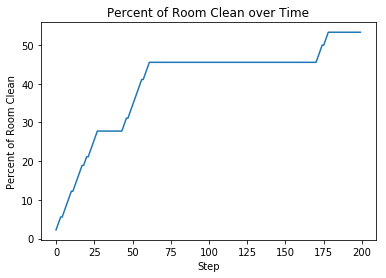

Strategy 2


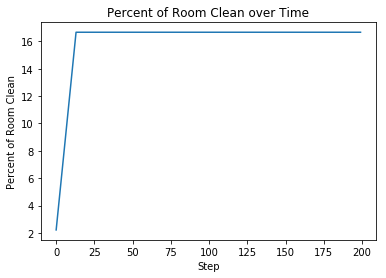

Strategy 3


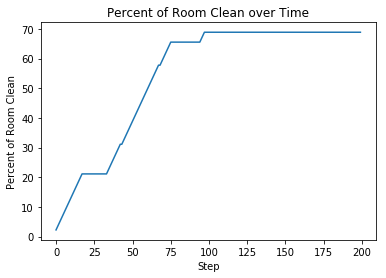

Strategy 4


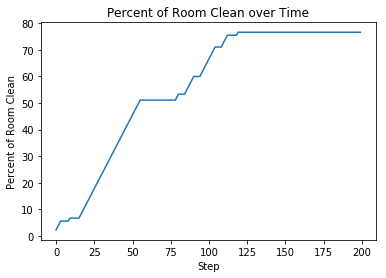

Strategy 5


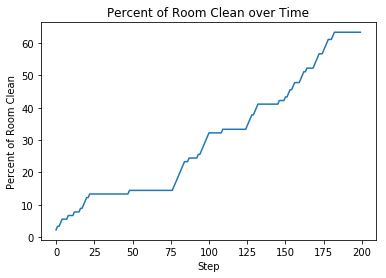

Strategy 6


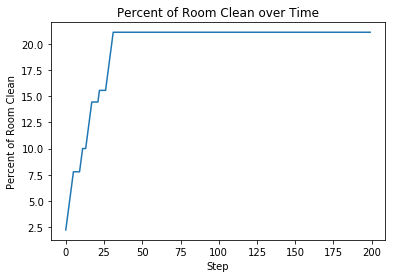

In [34]:
def run_sim(length, width, density, turn_prob, steps, strategy, strat_5, visualize):
    simul = Room(length, width, density, turn_prob, steps, strategy, strat_5, visualize)
    simul.start_simulation()
    plt.clf()
    plt.plot(simul.cum_clean)
    plt.ylabel('Percent of Room Clean')
    plt.xlabel('Step')
    plt.title('Percent of Room Clean over Time')
    plt.show()

for i in range(1, 7):
    print("Strategy %s" % i)
    run_sim(10, 10, .1, .5, 200, i, .2, False)


Red line = mean, green lines = upper and lower bounds of 95% confidence interval


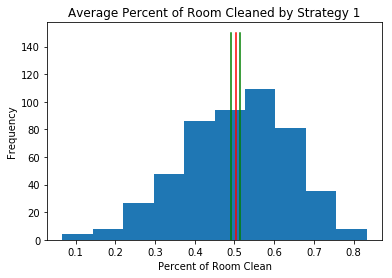

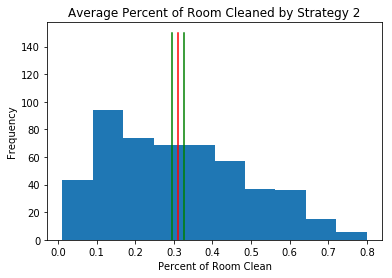

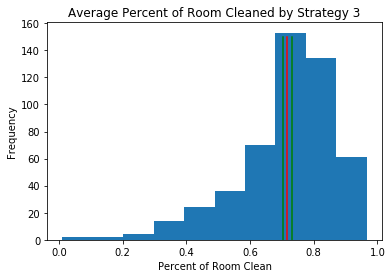

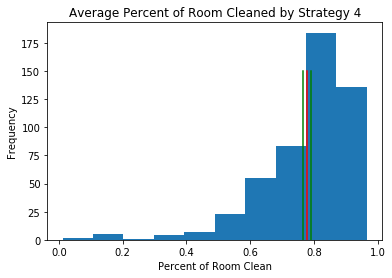

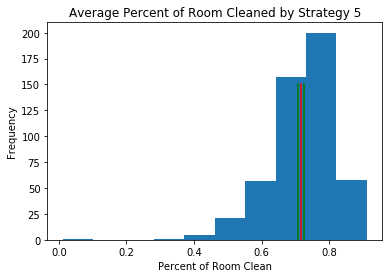

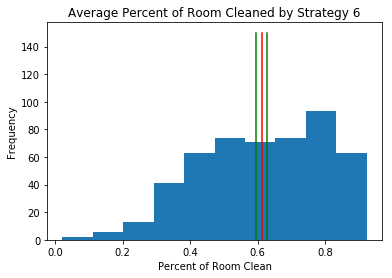

In [35]:
results = [[],[],[],[],[], []]

def run_sim(length, width, density, turn_prob, steps, strategy, strat_5, results):
    simul = Room(length, width, density, turn_prob, steps, strategy, strat_5)
    simul.start_simulation()
    results.append(simul.measure())

# following code taken from https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data/34474255
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
# end of code

print('Red line = mean, green lines = upper and lower bounds of 95% confidence interval')

for i in range(1, 7):
    for j in range(500):
        run_sim(10, 10, .1, .5, 200, i, .2, results[i-1])
    mean, lower, upper = mean_confidence_interval(results[i-1])
    plt.hist(results[i-1])
    plt.plot([mean, mean], [0, 150], 'r-')
    plt.plot([lower, lower], [0, 150], 'g-')
    plt.plot([upper, upper], [0, 150], 'g-')
    plt.title('Average Percent of Room Cleaned by Strategy %s' % i)
    plt.xlabel('Percent of Room Clean')
    plt.ylabel('Frequency')
    plt.show()

## Comments on results/further analysis
The confidence interval seems weirdly tight based on the shape of the histogram. However, histograms can be misleading because they don't show where the occurences in each bin actually are located. This probably explains the tight boundaries. The boundaries are quite tight, actually, suggesting that each of the strategies have consistent behaviors. This is probably because 200 steps is enough for each strategy to reach its peak percentage of room cleaned, with room to spare, so the strategy is most likely to clean as much of the room as it can based on the obstacle setup. And since the obstacle setup is random, it makes sense that we would see such consistent performances. In fact, the graphs in the preceding cell, showing the cleanliness progression over time, confirms my hypothesis that each strategy arrived at its peak cleanliness, usually well before it ran out of steps. The confidence intervals are also so tight because there were so many trials (500).

The random nature of the obstacle setup appears to have given all strategies a skewed normal distribution of performance. The better the strategy is, the more skewed to the left the performance is. 

## Advising My Roomba Boss
Based on the average success of each strategy, I would recommend either Strategy 4 or Strategy 5. They both had strong performances, consistently cleaning at least 80% of the rooms, although Strategy 4 did it more quickly. Frankly, they both do the job, even if they have different methods.  
That being said, I will lobby for Strategy 4. I believe that the methodic, back-and-forth nature of this strategy, cleaning rooms more consistently, will appeal to consumers. I think it also appeals to the mild obsessive-compulsive nature in all of us. Seeing a Roomba pace back and forth through a room, seeing its progress, is more appealing that seeing a Roomba move randomly, sporadically around a room, even if they do have essentially the same performance.

In [ ]:
for i in results:
    plt.plot(i)
    mean, lower, upper = mean_confidence_interval(i)
    plt.plot([mean, mean], [0, 150], 'r-')
    plt.plot([lower, lower], [0, 150], 'g-')
    plt.plot([upper, upper], [0, 150], 'g-')

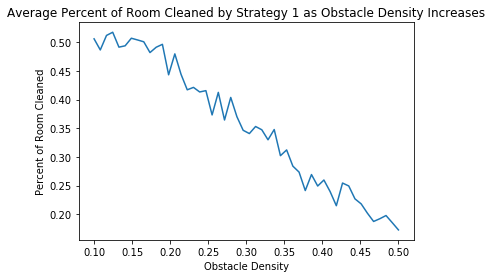

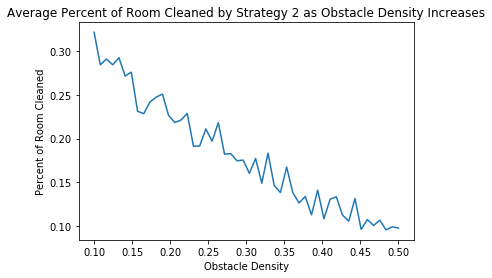

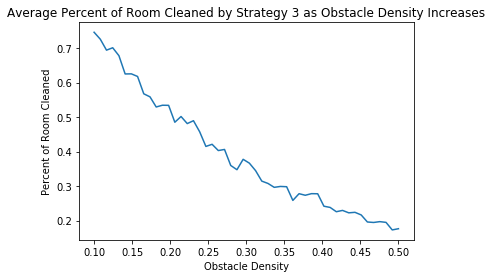

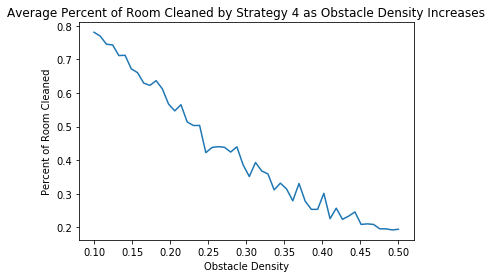

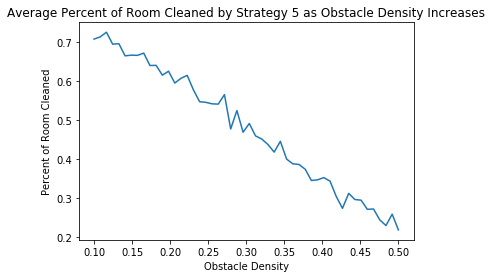

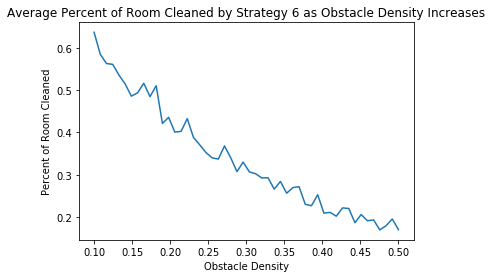

In [31]:
results = [[],[],[],[],[], []]

def run_sim(length, width, density, turn_prob, steps, strategy, strat_5, results):
    simul = Room(length, width, density, turn_prob, steps, strategy, strat_5)
    simul.start_simulation()
    results.append(simul.measure())

densities = np.linspace(.1, .5, 50)

for i in range(1, 7):
    for j in densities:
        outcomes = []
        for k in range(100):
            run_sim(10, 10, float(j), .5, 200, i, .2, outcomes)
        results[i-1].append(np.mean(outcomes))
            
    plt.plot(densities, results[i-1])
    plt.title('Average Percent of Room Cleaned by Strategy %s as Obstacle Density Increases' % i)
    plt.ylabel('Percent of Room Cleaned')
    plt.xlabel('Obstacle Density')
    plt.show()